# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [4]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
sns.set_style('darkgrid')

sns.set_style('darkgrid')

In [5]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

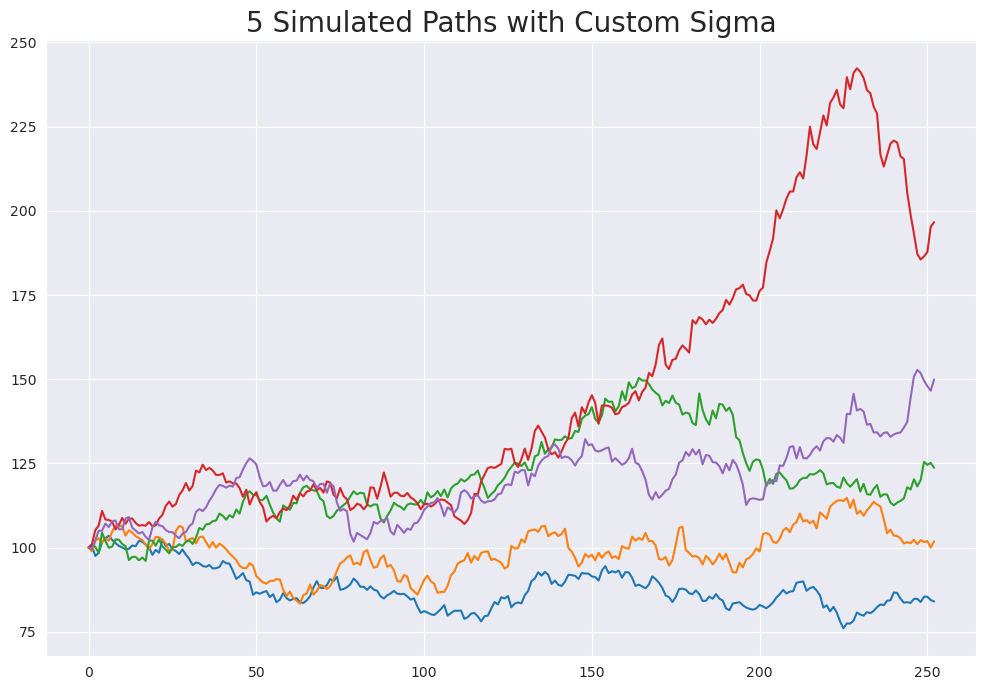

In [6]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

### Impact of Non-Constant Sigma on a Delta Hedge 


In [11]:
def bs_call(S, K, T, r, sigma):
    if T <= 0: return max(0, S - K)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_delta(S, K, T, r, sigma):
    if T <= 0: return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def stock_path_custom_sigma(S0, t, r, n_paths, n_steps):
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))
    sigma_path = np.random.choice([.2, .3, .45], p=[.5, .3, .2], size=(n_paths, n_steps))
    dt = t / n_steps
    increments = (r - .5 * sigma_path**2) * dt + sigma_path * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    return paths, sigma_path

In [12]:
# Delta hedging portfolio class

class HedgePortfolio:

    def __init__(self, S, K, T, r, sigma):
        # Store parameters
        self.S, self.K, self.T, self.r, self.sigma = S, K, T, r, sigma
        
        # --- Initial Hedge (t=0) ---
        # 1. Sell the call option
        self.cash = bs_call(S, K, T, r, sigma)
        
        # 2. Calculate initial delta and buy shares to hedge
        self.delta = bs_delta(S, K, T, r, sigma)
        self.stock = self.delta
        self.cash -= self.stock * S

    def rebalance(self, S, t_remaining):
        """
        Rebalances the hedge at each time step.
        """
        # Calculate new delta
        new_delta = bs_delta(S, self.K, t_remaining, self.r, self.sigma)
        
        # Trade shares to adjust hedge
        shares_to_trade = new_delta - self.stock
        self.cash -= shares_to_trade * S
        self.stock = new_delta
        
    def accrue_interest(self, dt):
        """
        Accrues interest on the cash account for one time step.
        """
        self.cash *= np.exp(self.r * dt)

    def unwind(self, S_final):
        """
        Calculates final P&L at expiration.
        """
        # Settle the short call option (a liability)
        option_payoff = max(0, S_final - self.K)
        self.cash -= option_payoff
        
        # Sell the shares held
        self.cash += self.stock * S_final
        self.stock = 0 # No shares left
        
        return self.cash

In [13]:
# Running the Delta hedging simulation 

# Simulation Parameters
S0 = 100.0
K = 100.0
r = 0.05
t = 1.0
n_steps = 252
n_paths = 5000 
assumed_sigma = 0.3 # The hedger's assumes a constant volatility (.3 is the weihted average)

# Generate stock paths with changing volatility
stock_paths, _ = stock_path_custom_sigma(S0, t, r, n_paths, n_steps)
dt = t / n_steps
pnl_list = []

for path in stock_paths:
    # Create a new portfolio for this path
    portfolio = HedgePortfolio(S=S0, K=K, T=t, r=r, sigma=assumed_sigma)
    
    # Rebalance daily
    for i in range(1, n_steps):
        time_rem = t - i * dt
        portfolio.accrue_interest(dt)
        portfolio.rebalance(S=path[i], t_remaining=time_rem)
        
    # Unwind at expiration
    pnl = portfolio.unwind(S_final=path[-1])
    pnl_list.append(pnl)

pnl_delta_hedge = np.array(pnl_list)

print("--- Delta Hedging P&L Statistics ---")
print(f"Mean P&L: {np.mean(pnl_delta_hedge):.4f}")
print(f"Std Dev of P&L (Hedging Error): {np.std(pnl_delta_hedge):.4f}")

--- Delta Hedging P&L Statistics ---
Mean P&L: 0.1825
Std Dev of P&L (Hedging Error): 0.8529


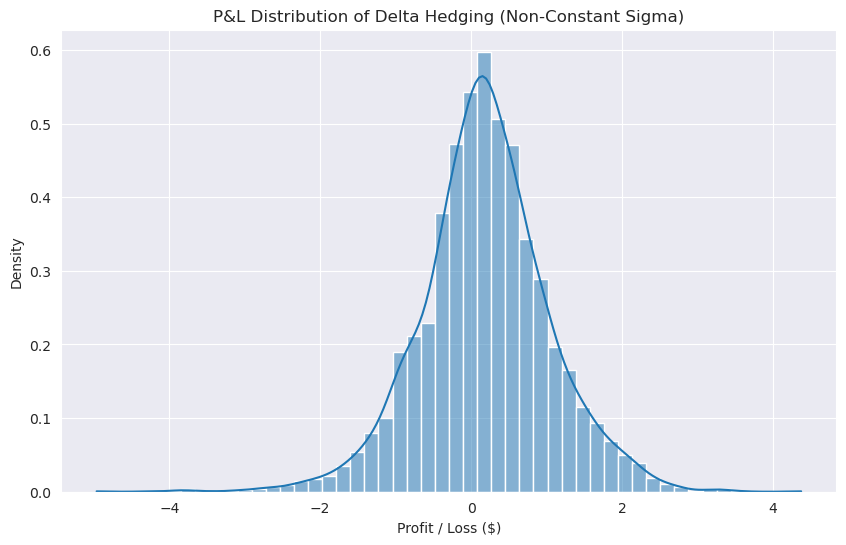


--- Control Variate Analysis ---
Original P&L Variance: 0.7274
Adjusted P&L Variance: 0.7274
Variance Reduction: 0.00%

Refined Mean P&L (using control variate): 0.1832


In [14]:
# P&L visualization and control variate analysis

plt.figure(figsize=(10, 6))
sns.histplot(pnl_delta_hedge, bins=50, kde=True, stat='density')
plt.title('P&L Distribution of Delta Hedging (Non-Constant Sigma)')
plt.xlabel('Profit / Loss ($)')
plt.ylabel('Density')
plt.show()

# Control Variate Adjustment 
# The P&L from a delta hedge is negatively correlated with the final stock price movement.
# We can use this to reduce the variance of our P&L estimate.

# Calculate the covariance between P&L and the stock price change
cov_matrix = np.cov(pnl_delta_hedge, stock_paths[:, -1] - S0)
cov_pnl_stock = cov_matrix[0, 1]
var_stock = cov_matrix[1, 1]

# Calculate the optimal control variate coefficient (b*)
b_optimal = -cov_pnl_stock / var_stock

# Adjust the P&L using the control variate
pnl_adjusted = pnl_delta_hedge + b_optimal * (stock_paths[:, -1] - S0)

print(f"\n--- Control Variate Analysis ---")
print(f"Original P&L Variance: {np.var(pnl_delta_hedge):.4f}")
print(f"Adjusted P&L Variance: {np.var(pnl_adjusted):.4f}")
print(f"Variance Reduction: {(1 - np.var(pnl_adjusted)/np.var(pnl_delta_hedge)) * 100:.2f}%")
print(f"\nRefined Mean P&L (using control variate): {np.mean(pnl_adjusted):.4f}")

### Exploring Hensen model for stochastic volatility

In [16]:
# Heston model path simulator

# Heston Model Parameters
kappa = 3.0       # Rate of mean reversion for variance
theta = 0.04      # Long-run average variance (sigma^2)
xi = 0.6          # Volatility of volatility (vol of vol)
rho = -0.7        # Correlation between stock and variance processes

def heston_paths(S0, t, r, kappa, theta, xi, rho, n_paths, n_steps):
    dt = t / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    v = np.zeros((n_paths, n_steps + 1))
    
    # Initial values
    paths[:, 0] = S0
    v[:, 0] = theta
    
    # Generate correlated random noise
    w_s = np.random.normal(size=(n_paths, n_steps))
    w_v_ind = np.random.normal(size=(n_paths, n_steps))
    w_v = rho * w_s + np.sqrt(1 - rho**2) * w_v_ind
    
    # Simulate paths step by step using Euler discretization
    for i in range(1, n_steps + 1):
        # Ensure variance is never negative (Full Truncation)
        v[:, i] = np.maximum(v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + xi * np.sqrt(v[:, i-1] * dt) * w_v[:, i-1], 0)
        paths[:, i] = paths[:, i-1] * np.exp((r - 0.5 * v[:, i-1]) * dt + np.sqrt(v[:, i-1] * dt) * w_s[:, i-1])
        
    return paths

In [17]:
# Running the Delta hedging simulation using Heston paths

pnl_heston_list = []

# Generate new stock paths using the Heston model
heston_stock_paths = heston_paths(S0, t, r, kappa, theta, xi, rho, n_paths, n_steps)

# Loop through each Heston path
for path in heston_stock_paths:
    # Use the same HedgePortfolio class as in Part A
    portfolio = HedgePortfolio(S=S0, K=K, T=t, r=r, sigma=assumed_sigma)
    
    # Rebalance daily
    for i in range(1, n_steps):
        time_rem = t - i * dt
        portfolio.accrue_interest(dt)
        portfolio.rebalance(S=path[i], t_remaining=time_rem)
        
    # Unwind at expiration
    pnl = portfolio.unwind(S_final=path[-1])
    pnl_heston_list.append(pnl)

pnl_delta_hedge_heston = np.array(pnl_heston_list)

print("--- Delta Hedging with Heston Model P&L Statistics ---")
print(f"Average P&L: {np.mean(pnl_delta_hedge_heston):.4f}")
print(f"Std Dev of P&L (Hedging Error): {np.std(pnl_delta_hedge_heston):.4f}")

--- Delta Hedging with Heston Model P&L Statistics ---
Average P&L: 4.1721
Std Dev of P&L (Hedging Error): 2.3315


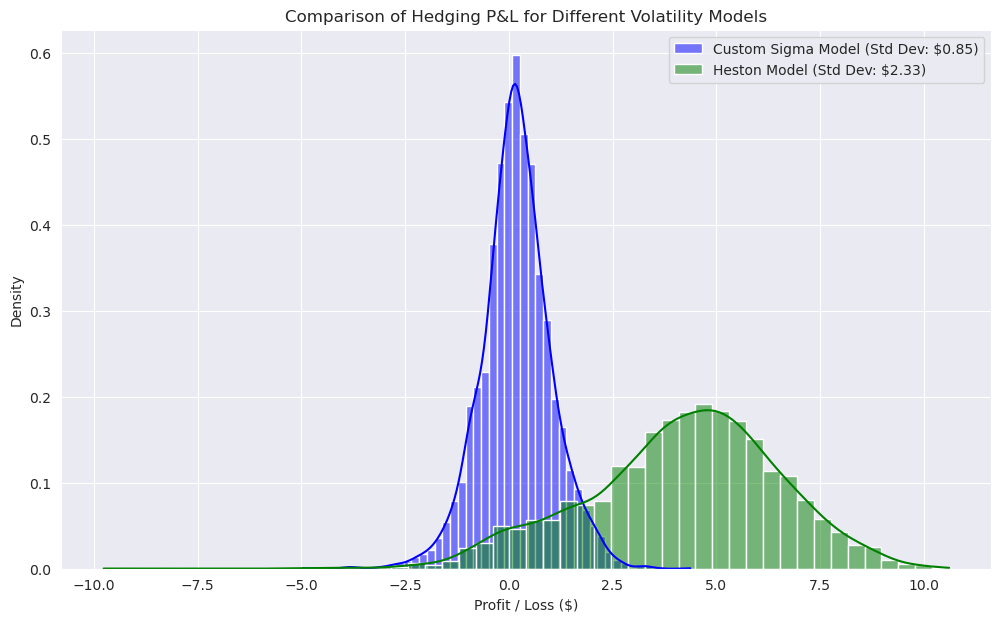


Observation: The shape and spread of the P&L distribution depend heavily on the underlying volatility model.
This shows that accurately modeling volatility is critical for managing hedge performance.


In [18]:
# P&L from custom sigma vs. Heston model

plt.figure(figsize=(12, 7))
sns.histplot(pnl_delta_hedge, bins=50, kde=True, color='blue', 
             label=f'Custom Sigma Model (Std Dev: ${np.std(pnl_delta_hedge):.2f})', stat='density')
sns.histplot(pnl_delta_hedge_heston, bins=50, kde=True, color='green', 
             label=f'Heston Model (Std Dev: ${np.std(pnl_delta_hedge_heston):.2f})', stat='density')

plt.title('Comparison of Hedging P&L for Different Volatility Models')
plt.xlabel('Profit / Loss ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

print("\nObservation: The shape and spread of the P&L distribution depend heavily on the underlying volatility model.")
print("This shows that accurately modeling volatility is critical for managing hedge performance.")